In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import os
from pathlib import Path 
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
def time_norm(data, time_n=np.linspace(0,100,101), axis=-1):
    own_time = np.linspace(time_n[0], time_n[-1], data.shape[0])
    a=data
    if np.isnan(a).any() and not(np.isnan(a).all()):
        first_non_nan = np.where(~np.isnan(a))[0][0]
        last_non_nan = np.where(~np.isnan(a))[0][-1]
        a_red=a[first_non_nan: last_non_nan+1]
        
        ratio_first = int(np.ceil(first_non_nan/len(a)*len(time_n)))
        ratio_last = int(np.floor(last_non_nan/len(a)*len(time_n)))
#         print(len())\n",
        a_red = fill_nan(a_red)
        f = interp1d(np.round(own_time[first_non_nan:last_non_nan+1],2), a_red, axis=axis, kind='cubic')
        try:
            y_red = f(time_n[ratio_first:ratio_last])
        except:
#             try:\n",
            print(f'Original x: {own_time[first_non_nan]} to {own_time[last_non_nan]} ')
            print(f'New x: {time_n[ratio_first]} to {time_n[ratio_last]} ')
            try:
                ratio_first +=1
                y_red = f(time_n[ratio_first:ratio_last])
            except:
                ratio_first +=1
                y_red = f(time_n[ratio_first:ratio_last])
        y = np.empty(len(time_n))
        y[:] = np.nan
        y[ratio_first:ratio_last]=y_red
#         plt.plot(own_time,a)
#         plt.plot(own_time[first_non_nan:last_non_nan+1], a_red)
#         plt.figure()
#         plt.plot(time_n, y)
    else:
        f = interp1d(own_time, a, axis=axis, kind='cubic')
        y = f(time_n)
    return y

In [3]:
PROJECT_PATH = Path("D:/Knee_Flexion_auditory_tactile_feedback/Analysis/results")
conf = pd.read_csv(PROJECT_PATH / '_conf.csv')
conf = conf[conf.process==1]
conf

,participant,age,height,mass,sex,leg,feedback_group,conf_file,process
0,P0,30,167,61,1,L,T,D:\Knee_Flexion_auditory_tactile_feedback\Anal...,1
1,N0,30,167,61,1,L,T,D:\Knee_Flexion_auditory_tactile_feedback\Anal...,1


C:\Users\naas625f\AppData\Local\Temp\ipykernel_8992\1957133242.py:9: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  markers = ['time']+[f"{imc}_{c}" for imc in [im for im in pd.read_csv(trc_path, header=3, sep='\t').columns if ('Unnamed' not in im)][2:] for c in ['tx', 'ty', 'tz']]
C:\Users\naas625f\AppData\Local\Temp\ipykernel_8992\1957133242.py:11: DtypeWarning: Columns (5,6,7,8,9,10,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  marker_trc = pd.read_csv(trc_path, header=4, sep='\t')


           time Marker  Distance [cm]              ID Participant        Trial
1012507  421.83      T       0.925416  N0_1st_session          N0  1st_session
1012508  421.84      T       0.940673  N0_1st_session          N0  1st_session
1012509  421.85      T       0.987272  N0_1st_session          N0  1st_session
1012510  421.86      T       0.903023  N0_1st_session          N0  1st_session
1012511  421.87      T       0.932023  N0_1st_session          N0  1st_session


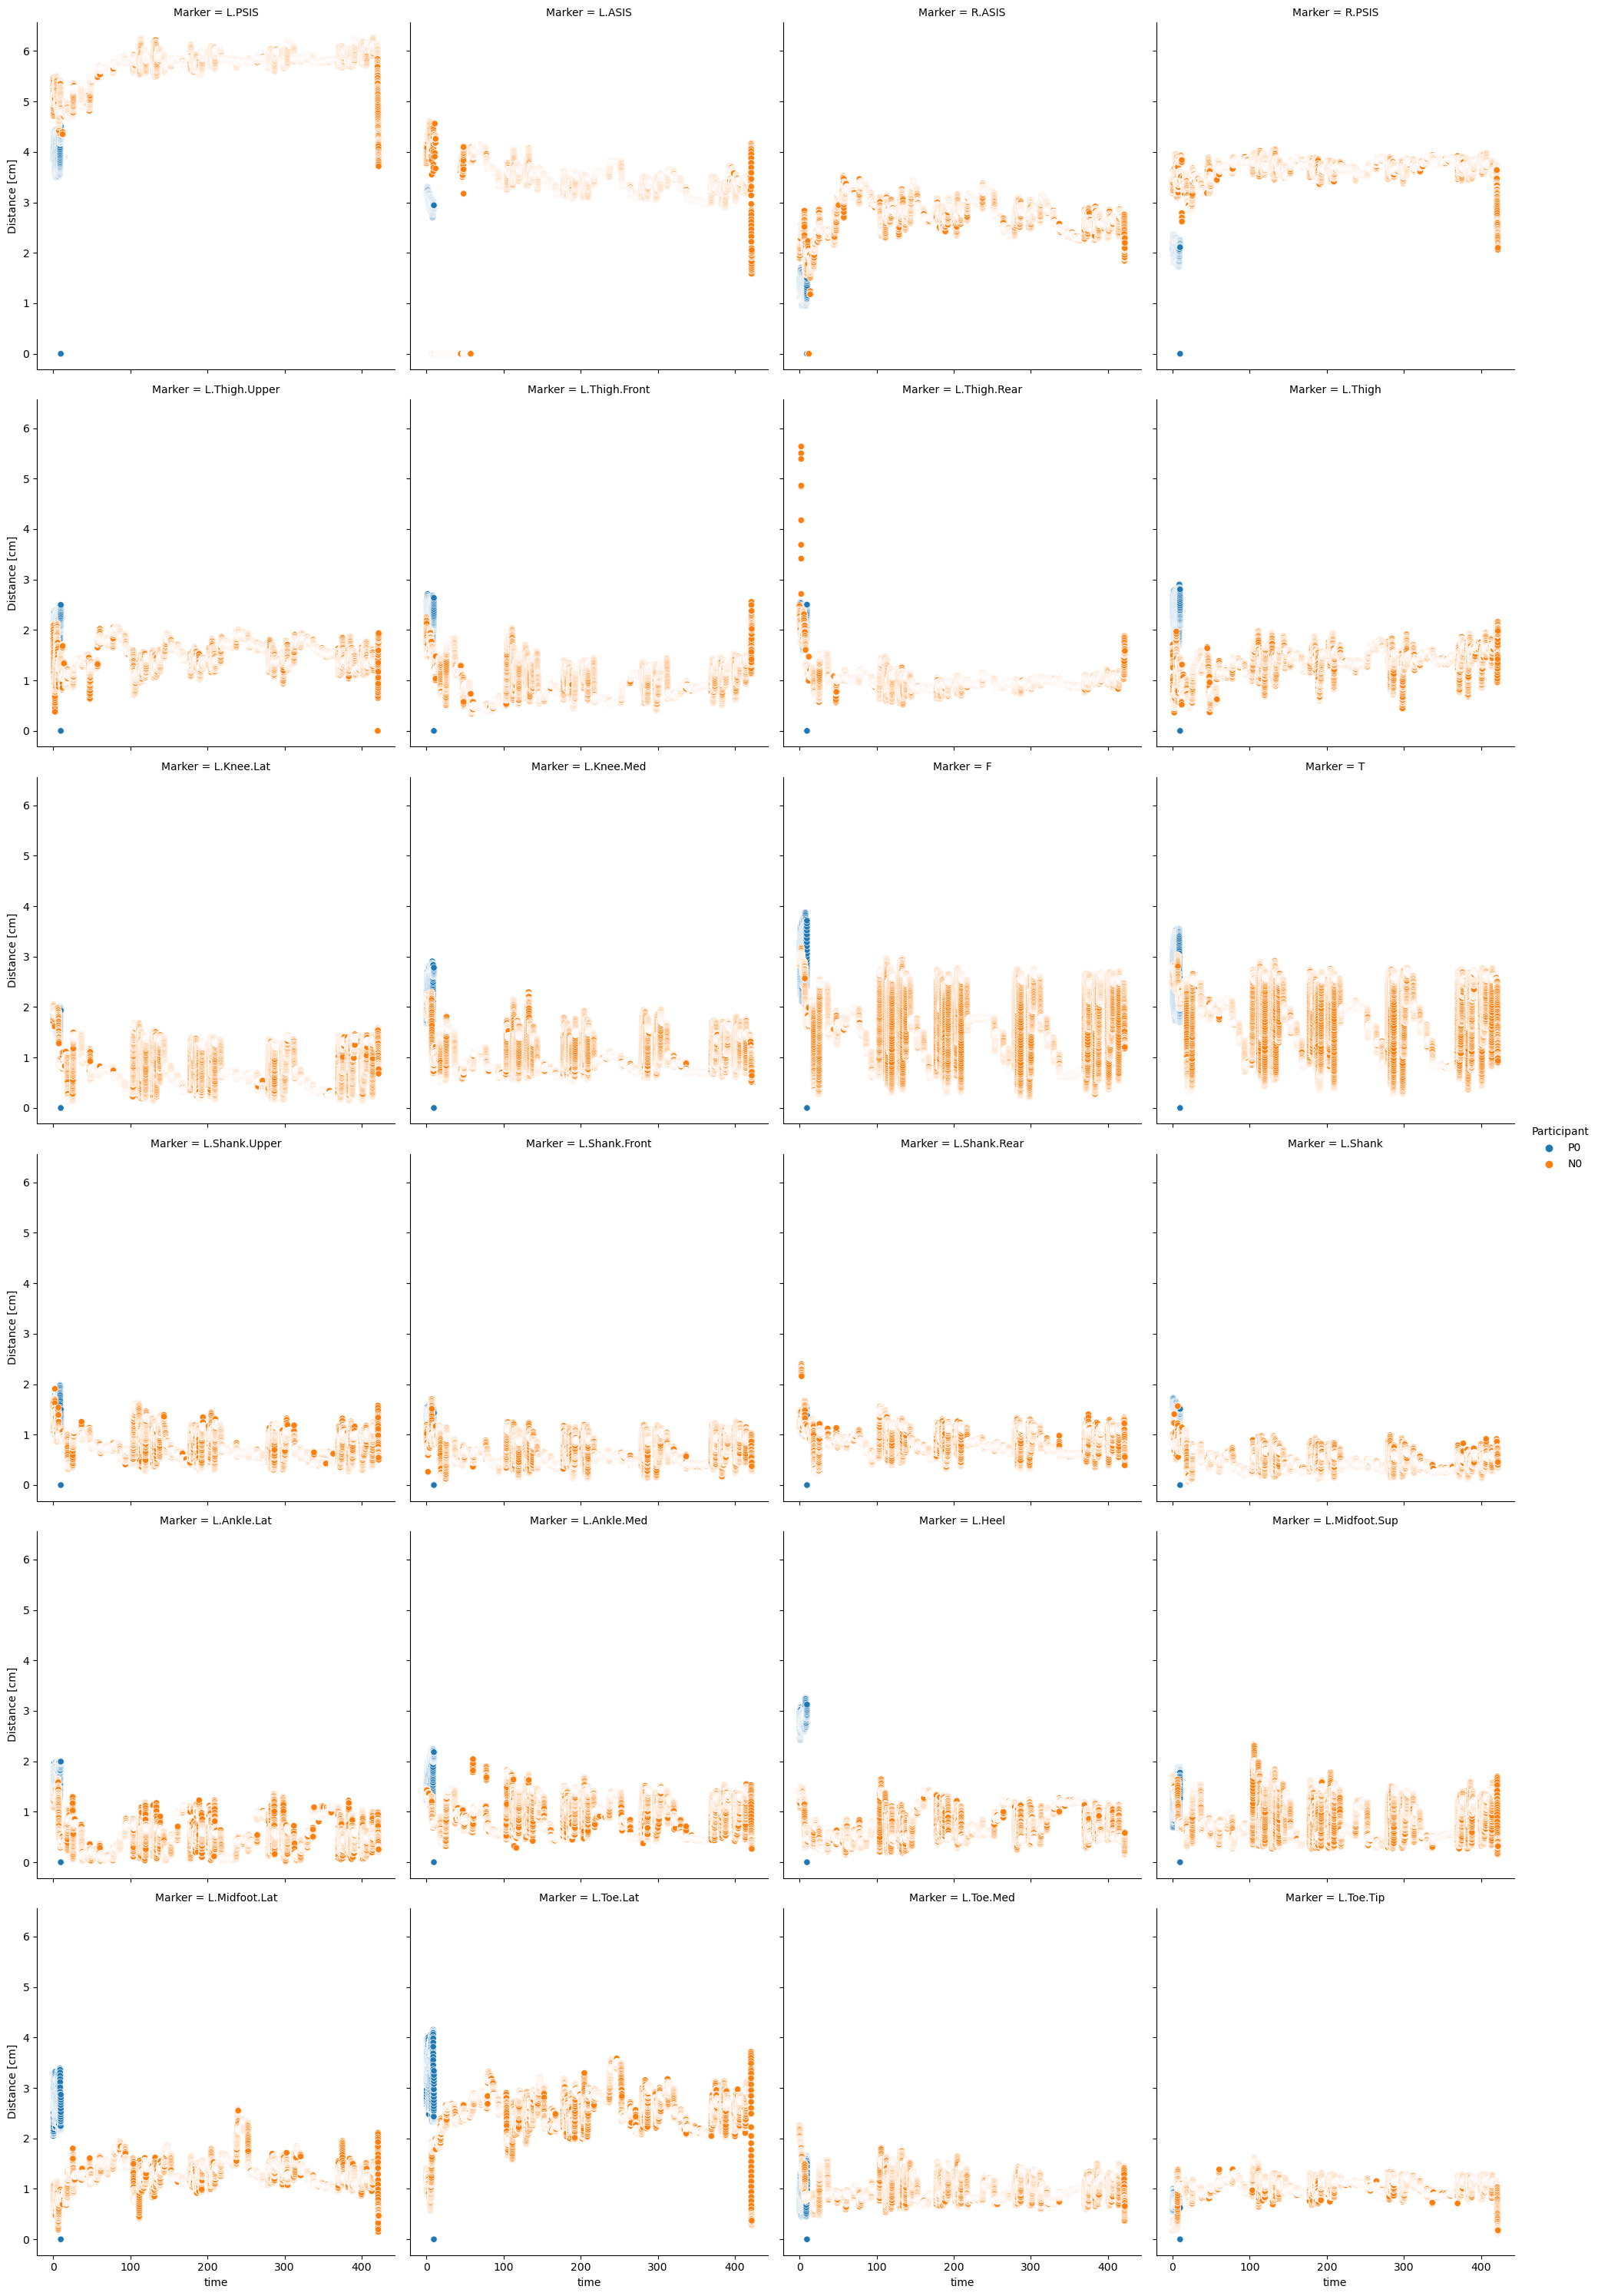

In [122]:
flexion_cycles = pd.DataFrame({'time' : np.linspace(0, 100, 101)})
all_df = []
for iparticipant in conf.participant[:]:
    lat = (conf[conf.participant == iparticipant]["leg"].values[0]).lower()
    mot_marker = [ifile for ifile in (PROJECT_PATH / iparticipant / "1_inverse_kinematic").glob("*.sto") if 'locations' in ifile.stem]
    
    for imot in mot_marker[:1]:
        trc_path = PROJECT_PATH / iparticipant / "0_markers" / f"{imot.stem[:-26]}.trc"
        markers = ['time']+[f"{imc}_{c}" for imc in [im for im in pd.read_csv(trc_path, header=3, sep='\t').columns if ('Unnamed' not in im)][2:] for c in ['tx', 'ty', 'tz']]
        
        marker_trc = pd.read_csv(trc_path, header=4, sep='\t')
        marker_trc = marker_trc.replace('-nan(ind)', np.nan).astype(float)
        marker_trc = marker_trc.iloc[:-20, 1:77]
        marker_trc.columns = markers
        marker_trc.drop(['P_tx', 'P_ty', 'P_tz'], axis=1, inplace=True)
        markers = marker_trc.columns
        
        marker_ik = pd.read_csv(imot, header=6, sep='\t', dtype=float)*1e3
        marker_ik = marker_ik[markers]
        marker_ik = marker_ik.iloc[:-20, :]
        
        diff_c = (marker_ik-marker_trc)**2
        diff = np.sqrt(diff_c.T.groupby([s.split('_')[0] for s in diff_c.T.index.values]).sum().T)/10
        diff.time = marker_trc.time
        all_df.append(diff.melt('time', var_name='Marker', value_name='Distance [cm]').assign(ID=f"{iparticipant}_{imot.stem[:-26]}"))
        
df = pd.concat(all_df)
df['Participant'] = [i.split('_')[0] for i in df.ID]
df['Trial'] = [i[3:] for i in df.ID]
g = sns.relplot(data=df, x='time', y='Distance [cm]', hue='Participant', size=None, style=None, col='Marker', col_wrap=4,
                col_order = ['L.PSIS', 'L.ASIS', 'R.ASIS','R.PSIS',
                             'L.Thigh.Upper','L.Thigh.Front','L.Thigh.Rear','L.Thigh',
                             'L.Knee.Lat','L.Knee.Med','F','T',
                             'L.Shank.Upper','L.Shank.Front','L.Shank.Rear','L.Shank',
                             'L.Ankle.Lat','L.Ankle.Med','L.Heel','L.Midfoot.Sup',
                             'L.Midfoot.Lat','L.Toe.Lat','L.Toe.Med','L.Toe.Tip'],
             dashes='Trial', style_order=None, legend='auto', kind='scatter', height=5, aspect=1,)

print(df.tail())
#         knee = ik[f'knee_angle_{lat}'].values
#         peaks, properties = find_peaks(knee, prominence = (50, 100))
#         for ipeak, peak in enumerate(peaks[:-1]):
#             one_flexion = knee[peak:peaks[ipeak+1]] 
#             new_column_name = iparticipant + '_' + imot.stem + '_' + str(ipeak)
#             d = 90 + time_norm(one_flexion) # move from opensim angle to experimental definition
#             flexion_cycles = flexion_cycles.join(pd.DataFrame({new_column_name : d}))
            

# df = flexion_cycles.melt('time', value_name='Flexion Angle')
# df['Participant'] = [i.split('_')[0] for i in df.variable]
# df['n_flexion'] = [i.split('_')[-1] for i in df.variable]
# df['Block'] = [i[3:-2] for i in df.variable]
# df.head()
# sns.lineplot(df, x='time', y='Flexion Angle', hue='Participant', style='Block')

In [126]:
all_df[-0].tail()

,time,Marker,Distance [cm],ID
23515,9.75,T,2.380296,P0_1st_session
23516,9.76,T,2.432780,P0_1st_session
23517,9.77,T,2.503239,P0_1st_session
23518,9.78,T,2.572791,P0_1st_session
23519,9.79,T,0.000000,P0_1st_session


In [127]:
all_df[-1].tail()

,time,Marker,Distance [cm],ID
1012507,421.83,T,0.925416,N0_1st_session
1012508,421.84,T,0.940673,N0_1st_session
1012509,421.85,T,0.987272,N0_1st_session
1012510,421.86,T,0.903023,N0_1st_session
1012511,421.87,T,0.932023,N0_1st_session
